In [1]:
import os
import cv2
import numpy as np
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, random_split, Subset


from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

import math
import random
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import seaborn as sns

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# --- Configuration ---
DATA_DIR = './data'
N_CLUSTERS = 1000    # BoVW 词典大小
MAX_KP = 500         # 每张图最大关键点数
PATCH_SIZE = 16     # 描述子 patch 大小
INTEREST_METHOD = 'Harris'  # 可选: 'DoG', 'Harris', 'LoG'
EPOCHS = 50
LR = 1e-3

In [3]:
# --- Setup MPS device ---
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

In [ ]:
# --- 1. Interest Point Detection ---
def detect_interest_points(gray, method='DoG', threshold=2.5):
    if method == 'DoG':
        # Define multiple sigma values for Gaussian blur
        num_octaves=3 # the level of the image pyramid
        scales_per_octave=3 # the number of scales per octave
        sigma0=1.6 # otiginal sigma value
        
        keypoints = []
        k = 2 ** (1 / scales_per_octave)  # 每层之间的尺度倍增因子
        
        # form the 0th octave to num_octaves-1 octaves
        for octave in range(num_octaves):
            # 1) create the base image for the current octave
            if octave == 0:
                base = gray.copy()
            else:
                # 下采样前一个 octave 的 base
                base = cv2.pyrDown(prev_base)
            
            # save the current base for the next octave
            prev_base = base
            # calculate the size of the base image
            h, w = base.shape
            
            # 2) 构建本 octave 的 Gaussian 金字塔
            #    需要做 (scales_per_octave + 3) 层，以便产生 scales_per_octave+2 个 DoG 层
            sigmas = [sigma0 * (k ** (i + octave*scales_per_octave)) for i in range(scales_per_octave + 3)]
            gaussians = [cv2.GaussianBlur(base, (0,0), sigmaX=s) for s in sigmas]
            
            # 3) 计算 DoG 图层
            dogs = []
            for i in range(len(gaussians)-1):
                diff = gaussians[i+1].astype(np.float32) - gaussians[i].astype(np.float32)
                dogs.append(diff)
            
            # 4) 在空间 + 尺度域寻找极值点
            #    只从第 1 层到倒数第 2 层做比较，因为要用前后层做上下尺度比较
            for i in range(1, len(dogs)-1):
                # the three layers to compare
                prev_d, curr_d, next_d = dogs[i-1], dogs[i], dogs[i+1]

                # max_spat and min_spat are masks of the same size as curr_d
                # 空间极值：用形态学膨胀/腐蚀检测局部极大/极小值
                # 对 curr_d 做形态学膨胀（dilation），相当于每个像素点被它 3×3 邻域内的最大值取代。
                #curr_d 在每个像素的 3×3 邻域内取最大值，输出也是一个 (H, W) 的数组——max_spat[y, x] 就是 curr_d 在 (y, x) 周围那 9 个点里的最大值。
                max_spat = cv2.dilate(curr_d, np.ones((3,3),np.uint8))
                # 做腐蚀（erosion），相当于每个像素点被邻域内的最小值取代。
                min_spat = cv2.erode( curr_d, np.ones((3,3),np.uint8))
                
                # 跨尺度极值：要比前一 DoG 和后一 DoG 都大（或都小）
                mask_max = (curr_d == max_spat) & (curr_d > prev_d) & (curr_d > next_d) & (np.abs(curr_d) > threshold)
                mask_min = (curr_d == min_spat) & (curr_d < prev_d) & (curr_d < next_d) & (np.abs(curr_d) > threshold)
                
                # Find all coordinates of the points that satisfy the conditions
                coords = np.vstack((np.argwhere(mask_max), np.argwhere(mask_min)))

                # 5) 将坐标映射回原图尺度并创建 KeyPoint
                for y, x in coords:
                    # 因为后面可能 downsample 了，需要乘回 2**octave
                    scale = (2 ** octave)

                    kp = cv2.KeyPoint(float(x*scale), float(y*scale), size=PATCH_SIZE * scale)
                    keypoints.append(kp)
                    
        # 最后按响应或数量截断
        keypoints = sorted(keypoints, key=lambda kp: kp.response if hasattr(kp, 'response') else 1.0,
                        reverse=True)
        # if len(keypoints) == 0:
        #     raise ValueError('No keypoints found')
        # else:
        #     print(f'Found {len(keypoints)} keypoints')
        return keypoints[:MAX_KP]
    elif method == 'Harris':
        # harris = cv2.cornerHarris(gray.astype(np.float32), 2, 3, 0.04)
        # coords = np.argwhere(harris > threshold * harris.max())
        # 1) Harris 响应
        H = cv2.cornerHarris(
            gray.astype(np.float32),
            blockSize=2,
            ksize=3,
            k=0.04
        )

        # 2) 归一化到 [0,1]
        Hn = cv2.normalize(H, None, 0, 1, cv2.NORM_MINMAX)

        # 3) 空间 NMS：只保留局部极大
        dil = cv2.dilate(Hn, np.ones((3,3), np.uint8))
        nms_mask = (Hn == dil)

        # 4) 阈值过滤：保留 Hn > thresh（如 0.01）
        mask = nms_mask & (Hn > 0.01)

        # 5) 包装成 KeyPoint
        ys, xs = np.where(mask)
        keypoints = []
        for y, x in zip(ys, xs):
            kp = cv2.KeyPoint(
                x=float(x), y=float(y),
                size=float(PATCH_SIZE),
                response=float(Hn[y, x])
            )
            keypoints.append(kp)

        # 6) 按 response 排序并截断
        keypoints.sort(key=lambda kp: kp.response, reverse=True)
        return keypoints[:MAX_KP]

        
    elif method == 'LoG':
        log = cv2.Laplacian(gray, cv2.CV_64F)
        coords = np.argwhere(np.abs(log) > threshold)
    else:
        sift = cv2.SIFT_create()
        kps = open_kps = sift.detect(gray, None)
        # raise ValueError('Unsupported method')
    # Create keypoints and limit count
    kps = [cv2.KeyPoint(float(x), float(y), size=PATCH_SIZE) for y, x in coords]

    return kps[:MAX_KP]

In [ ]:
# # --- 1. Interest Point Detection ---
# def detect_interest_points(gray, method='DoG', threshold=5):
#     # if method == 'DoG':
#     # Define multiple sigma values for Gaussian blur
#     num_octaves=3 # the level of the image pyramid
#     scales_per_octave=3 # the number of scales per octave
#     sigma0=1.6 # otiginal sigma value
#     harris_block = 2
#     harris_ksize = 3
#     harris_k = 0.04
#     harris_threshold = 0.01
#     max_per_octave = 200
    

#     harris_candidates = []
#     prev_base = None
#     for octave in range(num_octaves):
#         # 1) create the base image for the current octave
#         if octave == 0:
#             base = gray.copy()
#         else:
#             # 下采样前一个 octave 的 base
#             base = cv2.pyrDown(prev_base)
        
#         # save the current base for the next octave
#         prev_base = base
#         base_f = base.astype(np.float32)

#         H = cv2.cornerHarris(cv2.GaussianBlur(base, (0,0), sigmaX=sigma0),
#                             blockSize=harris_block,
#                             ksize=harris_ksize,
#                             k=harris_k)
#         # 归一化并阈值化找局部角点
#         Hn = cv2.normalize(H, None, 0, 1, cv2.NORM_MINMAX)
#         max_spat = cv2.dilate(Hn, np.ones((3,3), np.uint8))
#         mask = (Hn == max_spat) & (Hn > harris_threshold)

#         coords = np.argwhere(mask)
#         responses = [Hn[y, x] for y, x in coords]
#         idxs = np.argsort(responses)[::-1][:max_per_octave]  # sort by response
#         for y, x in coords:
#             harris_candidates.append((x, y, octave))
        
#     # 2) 一次性构建多 octave、多 scale 的 DoG 图层
#     dog_pyramid = []  # dog_pyramid[octave] = list of DoG layers for this octave
#     k = 2 ** (1 / scales_per_octave)
#     prev_base = None
#     for octave in range(num_octaves):
#         base = gray if octave == 0 else cv2.pyrDown(prev_base)
#         prev_base = base
#         # gaussian scales
#         sigmas = [sigma0 * (k ** (i + octave*scales_per_octave))
#                 for i in range(scales_per_octave + 3)]
#         gaussians = [cv2.GaussianBlur(base, (0,0), sigmaX=s) for s in sigmas]
#         dogs = [gaussians[i+1].astype(np.float32) - gaussians[i].astype(np.float32)
#                 for i in range(len(gaussians)-1)]
#         dog_pyramid.append(dogs)

#     seen = set()
    
#     # 3) 对每个 Harris 候选，做尺度选择：找出 DoG 响应绝对值最大的层
#     keypoints = []
#     for x, y, octave in harris_candidates:
#         dogs = dog_pyramid[octave]  # list of DoG layers at this octave
#         responses = [abs(dogs[i][y, x]) for i in range(len(dogs))]
#         best_i = int(np.argmax(responses))  # 最佳尺度对应的索引
#         # 对应的 sigma：
#         best_sigma = sigma0 * (k ** (best_i + octave*scales_per_octave))
#         # 创建 KeyPoint，坐标映射回原图
#         scale = 2 ** octave
#         X = x * scale
#         Y = y * scale
#         if (X, Y) in seen:
#             continue
#         kp = cv2.KeyPoint(
#             float(X),
#             float(Y),
#             size=PATCH_SIZE * scale  # 或者 PATCH_SIZE * scale
#         )
#         # 你也可以把 response 存入 kp.response: kp.response = responses[best_i]
#         kp.response = responses[best_i]
#         keypoints.append(kp)
                
#     keypoints = sorted(keypoints, key=lambda kp: kp.response if hasattr(kp, 'response') else 1.0, reverse=True)

#     # if len(keypoints) == 0:
#     #     raise ValueError('No keypoints found')
#     # else:
#     #     print(f'Found {len(keypoints)} keypoints')
#     return keypoints[:MAX_KP]

# # 24 18 11 15

In [ ]:
# --- Interest Point Detector: Harris-Laplace ---
def detect_interest_points(gray,
                            method=INTEREST_METHOD,
                            num_octaves=3,
                            scales_per_octave=3,
                            sigma0=1.6,
                            harris_block=2,
                            harris_ksize=3,
                            harris_k=0.04,
                            harris_thresh=0.01) -> list:
    """
    Harris-Laplace detector: combines multi-scale Harris corner detection for spatial localization
    with Laplacian-of-Gaussian for scale selection. Returns up to MAX_KP keypoints.
    """
    keypoints = []
    k = 2 ** (1 / scales_per_octave)
    # 1) Build Gaussian pyramid bases
    gp = []
    for octave in range(num_octaves):
        base = gray if octave == 0 else cv2.pyrDown(gp[-1])
        gp.append(base)

    # 2) Build Gaussian blurred images per octave
    gauss_pyr = []  # list of lists: gauss_pyr[octave][scale]
    for o, base in enumerate(gp):
        sigmas = [sigma0 * (k ** (i + o*scales_per_octave))
                  for i in range(scales_per_octave + 3)]
        gaussians = [cv2.GaussianBlur(base, (0,0), sigmaX=s) for s in sigmas]
        gauss_pyr.append(gaussians)

    # 3) Harris detection per scale (spatial localization)
    harris_pyr = []  # harris_pyr[octave][scale] = boolean mask
    for o, gaussians in enumerate(gauss_pyr):
        masks = []
        for img in gaussians:
            H = cv2.cornerHarris(np.float32(img), blockSize=harris_block,
                                 ksize=harris_ksize, k=harris_k)
            Hn = cv2.normalize(H, None, 0, 1, cv2.NORM_MINMAX)
            # spatial Non-Max Suppression
            max_spat = cv2.dilate(Hn, np.ones((3,3), np.uint8))
            mask = (Hn == max_spat) & (Hn > harris_thresh)
            masks.append(mask)
        harris_pyr.append(masks)

    # 4) Compute Laplacian-of-Gaussian responses per scale for scale selection
    log_pyr = []  # log_pyr[octave][scale]
    for gaussians in gauss_pyr:
        logs = [cv2.Laplacian(img, cv2.CV_32F, ksize=3) for img in gaussians]
        log_pyr.append(logs)

    # 5) Combine: for each Harris candidate, pick scale with max |LoG|
    seen = set()
    for o, masks in enumerate(harris_pyr):
        for s_idx, mask in enumerate(masks):
            ys, xs = np.where(mask)
            for y, x in zip(ys, xs):
                # scale selection
                responses = [abs(log_pyr[o][i][y, x]) for i in range(len(log_pyr[o]))]
                best_i = int(np.argmax(responses))
                # map to original image coordinates
                scale_factor = 2 ** o
                X = int(x * scale_factor)
                Y = int(y * scale_factor)
                if (X, Y) in seen:
                    continue
                seen.add((X, Y))
                # size proportional to sigma
                best_sigma = sigma0 * (k ** (best_i + o*scales_per_octave))
                size = PATCH_SIZE * best_sigma
                kp = cv2.KeyPoint(float(X), float(Y), size)
                kp.response = responses[best_i]
                keypoints.append(kp)

    # 6) sort by response and limit
    keypoints.sort(key=lambda kp: kp.response, reverse=True)
    return keypoints[:MAX_KP]
# 22 19 19 12

In [6]:
# --- 2. Compute Custom SIFT-like Descriptor ---
def compute_custom_sift_descriptor(gray, keypoints, patch_size=PATCH_SIZE):
    # Compute gradients once
    grad_x = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    mag = cv2.magnitude(grad_x, grad_y)
    ori = cv2.phase(grad_x, grad_y, angleInDegrees=True)

    descriptors = []
    half = patch_size // 2
    h, w = gray.shape

    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        # boundary check
        if x-half < 0 or y-half < 0 or x+half >= w or y+half >= h:
            continue
        # extract full patch
        mag_full = mag[y-half:y+half, x-half:x+half]
        ori_full = ori[y-half:y+half, x-half:x+half]
        # 1) Orientation assignment: build 36-bin histogram over full patch
        hist8, bin_edges = np.histogram(
            ori_full.ravel(), bins=8, range=(0,360), weights=mag_full.ravel()
        )
        # main orientation is center of max bin
        max_idx = np.argmax(hist8)
        main_ori = (bin_edges[max_idx] + bin_edges[max_idx+1]) / 2.0
        # normalize full patch orientations relative to main orientation
        ori_full = (ori_full - main_ori + 360) % 360

        # slice into subregions and build descriptor
        desc = []
        for i in range(4):
            for j in range(4):
                sub_mag = mag_full[i*4:(i+1)*4, j*4:(j+1)*4].ravel()
                sub_ori = ori_full[i*4:(i+1)*4, j*4:(j+1)*4].ravel()
                # 2) histogram on aligned orientations
                hsub, _ = np.histogram(sub_ori, bins=8, range=(0,360), weights=sub_mag)
                desc.extend(hsub)
        desc = np.array(desc, dtype=np.float32)
        desc /= (np.linalg.norm(desc) + 1e-7)
        descriptors.append(desc)

    # if len(descriptors) == 0:
    #     raise ValueError('No descriptors found')
    # else:
    #     print(f'Found {len(descriptors)} descriptors')
    # print(f'Found {len(descriptors)} descriptors')

    return np.array(descriptors) if descriptors else None

In [7]:
def get_mean_std(train_dir):
    # 1. 定义只做 ToTensor 的 transform（将像素从 [0,255] 归一到 [0,1]）
    to_tensor = transforms.ToTensor()

    # 2. 用 ImageFolder 加载训练集（不做任何裁剪／增强）
    dataset = torchvision.datasets.ImageFolder(train_dir, transform=to_tensor)

    # 3. 构造 DataLoader，顺序读取所有样本
    loader = DataLoader(
        dataset,
        batch_size=64,
        shuffle=False,      # 不打乱，顺序也没关系
        num_workers=4
    )

    # 4. 累加器：记录所有像素的总和与平方和，以及总像素数
    sum_rgb     = torch.zeros(3)  # 各通道所有像素之和
    sum_sq_rgb  = torch.zeros(3)  # 各通道所有像素平方之和
    total_pixels = 0              # 所有图片的像素总数（batch * H * W）

    # 5. 遍历 DataLoader，累加求和
    for imgs, _ in loader:
        # imgs: Tensor of shape (B, 3, H, W), 值在 [0,1]
        b, c, h, w = imgs.shape

        # 累加像素值
        # 对 (B,3,H,W) 张量按 dim=[0,2,3] 求和，得到 (3,) 向量
        sum_rgb    += imgs.sum(dim=[0, 2, 3])
        sum_sq_rgb += (imgs ** 2).sum(dim=[0, 2, 3])

        # 累加像素总数
        total_pixels += b * h * w

    # 6. 计算均值与标准差
    # mean = E[x]
    mean = sum_rgb / total_pixels
    # std  = sqrt(E[x^2] - (E[x])^2)
    std  = (sum_sq_rgb / total_pixels - mean ** 2).sqrt()

    return mean, std

train_dir = 'data/iCubWorld/train'
mean, std = get_mean_std(train_dir)
print('Dataset mean:', mean.tolist())
print('Dataset std :', std.tolist())

Dataset mean: [0.4298136234283447, 0.39438438415527344, 0.36725589632987976]
Dataset std : [0.22690562903881073, 0.20988260209560394, 0.19859203696250916]


In [8]:
transform_train = transforms.Compose([
    # —— PIL Image 处理 ——  
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2),# saturation=0.2, hue=0.1),
    # transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.25),
    # transforms.RandomVerticalFlip(),

    # —— 转 Tensor 并归一化到 [0,1] ——  
    transforms.ToTensor(),

    # —— Tensor-only 操作 ——  
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.05), ratio=(0.3, 3.3)),
    # transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),        # 或 Resize((256,256))
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std),
])

root_dir = 'data/iCubWorld'
trainset = torchvision.datasets.ImageFolder(os.path.join(root_dir, 'train'),transform=transform_train)
# testset  = CIFAR10(DATA_DIR, train=False, download=True, transform=transform)
test_bg = torchvision.datasets.ImageFolder(os.path.join(root_dir, 'test/background'), transform=transform_test)
test_cat = torchvision.datasets.ImageFolder(os.path.join(root_dir, 'test/categorization'), transform=transform_test)
test_demo = torchvision.datasets.ImageFolder(os.path.join(root_dir, 'test/demonstrator'), transform=transform_test)
test_robot = torchvision.datasets.ImageFolder(os.path.join(root_dir, 'test/robot'), transform=transform_test)

# test_sets = [test_bg, test_cat, test_demo, test_robot]
test_sets = {}
test_sets['background'] = test_bg
test_sets['categorization'] = test_cat
test_sets['demonstrator'] = test_demo
test_sets['robot'] = test_robot

### Add val

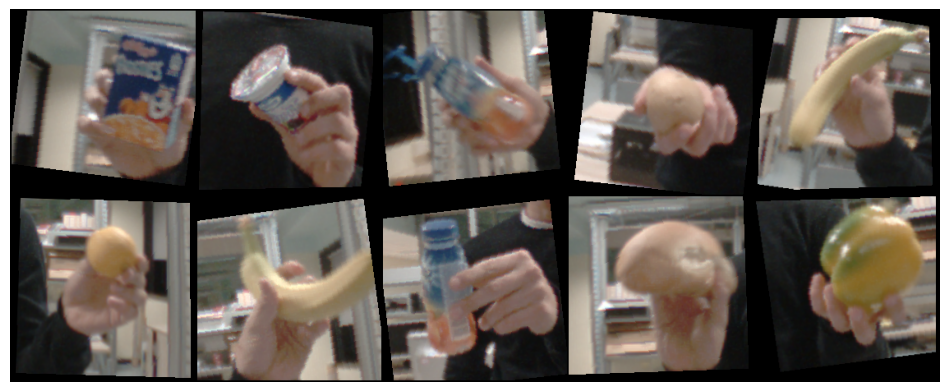

In [9]:
# 3. 准备逆标准化，以便可视化
# mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
# std  = torch.tensor([0.2470, 0.2435, 0.2616]).view(3,1,1)
# inv_norm = transforms.Normalize((-mean/std).squeeze(), (1/std).squeeze())

indices = random.sample(range(len(trainset)), 10)
imgs = []
for idx in indices:
    img, _ = trainset[idx]      # 返回 (C,H,W) tensor
    # img = inv_norm(img)        # 逆归一化到 [0,1]
    # img = torch.clamp(img, 0, 1)
    imgs.append(img)

grid = make_grid(imgs, nrow=5, padding=2)
plt.figure(figsize=(12, 6))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [26]:
# --- 4. Extract descriptors from training set ---
all_desc = []
img_desc_idx = []
train_labels = []
print('Extracting training descriptors...')
for img, label in tqdm(trainset, desc='Train images'):
    img_np = (img.numpy().transpose(1,2,0) * 255).astype(np.uint8)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    kps = detect_interest_points(gray, method=INTEREST_METHOD)
    # print(f'Found {len(kps)} keypoints in image {label}')
    des = compute_custom_sift_descriptor(gray, kps)
    if des is not None:
        all_desc.extend(des)
    img_desc_idx.append(len(all_desc))
    train_labels.append(label)
if len(all_desc) == 0:
    raise RuntimeError(
        "No descriptors found in any training image! "
        "请检查 detect_interest_points 或 compute_custom_sift_descriptor 是否过于严格，"
        "导致所有图像都跳过了。"
    )
else:
    all_desc = np.vstack(all_desc)

Extracting training descriptors...


Train images: 100%|██████████| 6002/6002 [21:49<00:00,  4.58it/s]


In [27]:
# --- 5. Build visual vocabulary ---
kmeans = MiniBatchKMeans(n_clusters=N_CLUSTERS, batch_size=1000, verbose=1)
kmeans.fit(all_desc)

Init 1/1 with method k-means++
Inertia for init 1/1: 1404.1414794921875
[MiniBatchKMeans] Reassigning 500 cluster centers.
Minibatch step 1/267427: mean batch inertia: 0.47593939208984376
[MiniBatchKMeans] Reassigning 380 cluster centers.
Minibatch step 2/267427: mean batch inertia: 0.4500355224609375, ewa inertia: 0.4500355224609375
Minibatch step 3/267427: mean batch inertia: 0.422970947265625, ewa inertia: 0.4500152817787374
Minibatch step 4/267427: mean batch inertia: 0.39936788940429685, ewa inertia: 0.4499774043036277
Minibatch step 5/267427: mean batch inertia: 0.3853727111816406, ewa inertia: 0.4499290886344299
Minibatch step 6/267427: mean batch inertia: 0.38605419921875, ewa inertia: 0.44988131876078885
Minibatch step 7/267427: mean batch inertia: 0.381953857421875, ewa inertia: 0.44983051810540453
Minibatch step 8/267427: mean batch inertia: 0.37414031982421875, ewa inertia: 0.4497739119610991
Minibatch step 9/267427: mean batch inertia: 0.37274249267578125, ewa inertia: 0.4

MiniBatchKMeans(batch_size=1000, n_clusters=1000, verbose=1)

In [28]:
# --- 6. Build BoVW features for train ---
def build_bovw(descriptors):
    words = kmeans.predict(descriptors)
    hist, _ = np.histogram(words, bins=np.arange(N_CLUSTERS+1))
    return hist.astype(float) / (hist.sum() + 1e-7)

train_feats = []
start = 0
# for idx in img_desc_idx:
for idx in tqdm(img_desc_idx, desc='Building BoVW features'):
    end = idx
    if end - start > 0:
        train_feats.append(build_bovw(all_desc[start:end]))
    else:
        train_feats.append(np.zeros(N_CLUSTERS, dtype=float))
    start = end
train_feats = np.array(train_feats)
train_labels = np.array(train_labels)

Building BoVW features: 100%|██████████| 6002/6002 [00:03<00:00, 1800.74it/s]


In [ ]:
# # --- 7. Extract BoVW features for test set ---
# test_feats = []
# test_labels = []
# print('Extracting test BoVW features...')
# for img, label in tqdm(testset, desc='Test images'):
#     img_np = (img.numpy().transpose(1,2,0) * 255).astype(np.uint8)
#     gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
#     kps = detect_interest_points(gray, method=INTEREST_METHOD)
#     des = compute_custom_sift_descriptor(gray, kps)
#     if des is not None:
#         hist = build_bovw(des)
#     else:
#         hist = np.zeros(N_CLUSTERS, dtype=float)
#     test_feats.append(hist)
#     test_labels.append(label)

# test_feats = np.array(test_feats)
# test_labels = np.array(test_labels)

In [29]:
test_feats_list = []
test_labels_list = []
for type, testset in test_sets.items():
    test_feats = []
    test_labels = []
    print(f'Extracting test BoVW features for set {type}...')
    for img, label in tqdm(testset, desc='Test images'):
        img_np = (img.numpy().transpose(1,2,0) * 255).astype(np.uint8)
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        kps = detect_interest_points(gray, method=INTEREST_METHOD)
        des = compute_custom_sift_descriptor(gray, kps)
        if des is not None:
            hist = build_bovw(des)
        else:
            hist = np.zeros(N_CLUSTERS, dtype=float)
        test_feats.append(hist)
        test_labels.append(label)

    test_feats_list.append(np.array(test_feats))
    test_labels_list.append(np.array(test_labels))

Extracting test BoVW features for set background...


Test images: 100%|██████████| 200/200 [00:25<00:00,  7.89it/s]


Extracting test BoVW features for set categorization...


Test images: 100%|██████████| 2001/2001 [06:36<00:00,  5.05it/s]


Extracting test BoVW features for set demonstrator...


Test images: 100%|██████████| 2001/2001 [06:37<00:00,  5.04it/s]


Extracting test BoVW features for set robot...


Test images: 100%|██████████| 802/802 [02:55<00:00,  4.57it/s]


## Softmax

In [ ]:
# # --- 8. Train Softmax Regression (Logistic Regression) on MPS ---
# # Prepare PyTorch tensors
# X_train = torch.from_numpy(train_feats).float().to(device)
# y_train = torch.from_numpy(train_labels).long().to(device)
# X_test  = torch.from_numpy(test_feats).float().to(device)
# y_test  = torch.from_numpy(test_labels).long().to(device)

# # Define simple linear model
# # model = nn.Linear(N_CLUSTERS, 10).to(device)
# # 在定义模型时
# model = nn.Sequential(
#     nn.BatchNorm1d(N_CLUSTERS),
#     nn.Linear(N_CLUSTERS, 10)
# ).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)

# print('Training Softmax Regression...')
# for ep in range(1, EPOCHS+1):
#     model.train()
#     optimizer.zero_grad()
#     outputs = model(X_train)
#     loss = criterion(outputs, y_train)
#     loss.backward()
#     optimizer.step()
#     if ep % 5 == 0:
#         print(f'Epoch {ep}/{EPOCHS}, loss={loss.item():.4f}')

In [30]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# 1) 准备 TensorDataset 并分出训练/验证集
full_ds = TensorDataset(
    torch.from_numpy(train_feats).float(),
    torch.from_numpy(train_labels).long()
)
train_n = int(0.9 * len(full_ds))
val_n   = len(full_ds) - train_n
train_ds, val_ds = random_split(full_ds, [train_n, val_n])

# 2) DataLoader
batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)

# 3) 定义模型/损失/优化
model = nn.Sequential(
    nn.BatchNorm1d(N_CLUSTERS),
    nn.Linear(N_CLUSTERS, 10)
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)

# 4) 训练＋验证＋保存最优模型
best_val_acc = 0.0
best_path    = 'best_model.pt'

print("Start training with validation, saving best model to", best_path)
for ep in range(1, EPOCHS+1):
    # ---- 训练 ----
    model.train()
    train_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * Xb.size(0)
    train_loss /= train_n

    # ---- 验证 ----
    model.eval()
    val_loss = 0.0
    correct  = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            out = model(Xb)
            val_loss += criterion(out, yb).item() * Xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
    val_loss /= val_n
    val_acc  = correct / val_n

    # ---- 保存最优模型 ----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)
        print(f"Epoch {ep}: New best val_acc = {val_acc:.4f}, saved to {best_path}")

    # ---- 日志打印 ----
    if ep == 1 or ep % 5 == 0:
        print(f"Epoch {ep}/{EPOCHS} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc:  {val_acc:.4f}")

Start training with validation, saving best model to best_model.pt
Epoch 1: New best val_acc = 0.1131, saved to best_model.pt
Epoch 1/50 | Train Loss: 2.2030 | Val Loss: 2.2984 | Val Acc:  0.1131
Epoch 2: New best val_acc = 0.1997, saved to best_model.pt
Epoch 3: New best val_acc = 0.3627, saved to best_model.pt
Epoch 4: New best val_acc = 0.3744, saved to best_model.pt
Epoch 5: New best val_acc = 0.4060, saved to best_model.pt
Epoch 5/50 | Train Loss: 1.5010 | Val Loss: 1.7896 | Val Acc:  0.4060
Epoch 6: New best val_acc = 0.4210, saved to best_model.pt
Epoch 7: New best val_acc = 0.4293, saved to best_model.pt
Epoch 8: New best val_acc = 0.4359, saved to best_model.pt
Epoch 10/50 | Train Loss: 1.1446 | Val Loss: 1.6155 | Val Acc:  0.4243
Epoch 11: New best val_acc = 0.4542, saved to best_model.pt
Epoch 15/50 | Train Loss: 0.9368 | Val Loss: 1.6128 | Val Acc:  0.4326
Epoch 20/50 | Train Loss: 0.8016 | Val Loss: 1.6788 | Val Acc:  0.4160
Epoch 25/50 | Train Loss: 0.6965 | Val Loss: 1.7

In [ ]:
# # --- 9. Evaluate on test set ---
# model.eval()
# with torch.no_grad():
#     preds = model(X_test).argmax(dim=1)
#     acc = (preds == y_test).float().mean().item()
# print(f'Test Accuracy: {acc:.4f}')
# # Convert MPS tensor to CPU numpy for classification_report
# preds_np = preds.cpu().numpy()
# print(classification_report(test_labels, preds_np))

Test Accuracy: 0.3900
              precision    recall  f1-score   support

     bananas       0.33      0.25      0.29        20
     bottles       0.44      0.40      0.42        20
       boxes       0.24      0.60      0.35        20
       bread       0.45      0.25      0.32        20
        cans       0.50      0.45      0.47        20
      lemons       0.40      0.40      0.40        20
       pears       0.53      0.50      0.51        20
     peppers       0.40      0.30      0.34        20
    potatoes       0.44      0.40      0.42        20
      yogurt       0.41      0.35      0.38        20

    accuracy                           0.39       200
   macro avg       0.42      0.39      0.39       200
weighted avg       0.42      0.39      0.39       200



/var/folders/y0/5zx_gdxj5rvb7c3v91ml3v780000gn/T/ipykernel_79540/1332452669.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, m

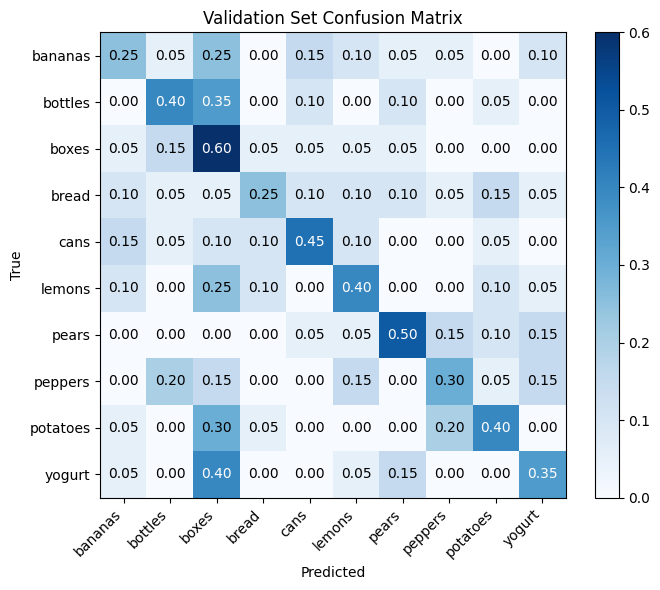

Test Accuracy: 0.2389
              precision    recall  f1-score   support

     bananas       0.16      0.09      0.12       200
     bottles       0.20      0.43      0.27       200
       boxes       0.34      0.11      0.17       200
       bread       0.24      0.24      0.24       200
        cans       0.22      0.20      0.21       200
      lemons       0.42      0.45      0.43       200
       pears       0.26      0.33      0.29       200
     peppers       0.12      0.16      0.14       200
    potatoes       0.32      0.15      0.20       200
      yogurt       0.25      0.23      0.24       201

    accuracy                           0.24      2001
   macro avg       0.25      0.24      0.23      2001
weighted avg       0.25      0.24      0.23      2001



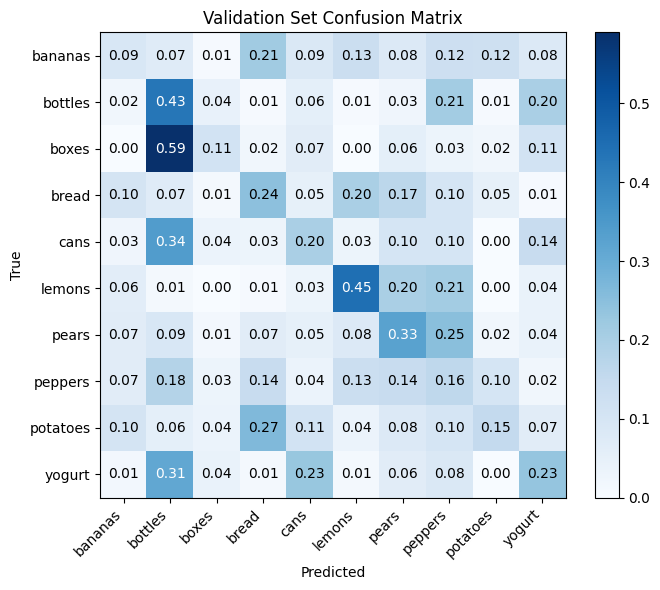

Test Accuracy: 0.2509
              precision    recall  f1-score   support

     bananas       0.10      0.01      0.01       200
     bottles       0.32      0.52      0.39       200
       boxes       0.60      0.43      0.50       200
       bread       0.30      0.56      0.39       200
        cans       0.20      0.15      0.17       200
      lemons       0.25      0.14      0.18       200
       pears       0.12      0.17      0.14       201
     peppers       0.31      0.21      0.25       200
    potatoes       0.17      0.15      0.16       200
      yogurt       0.12      0.17      0.14       200

    accuracy                           0.25      2001
   macro avg       0.25      0.25      0.23      2001
weighted avg       0.25      0.25      0.23      2001



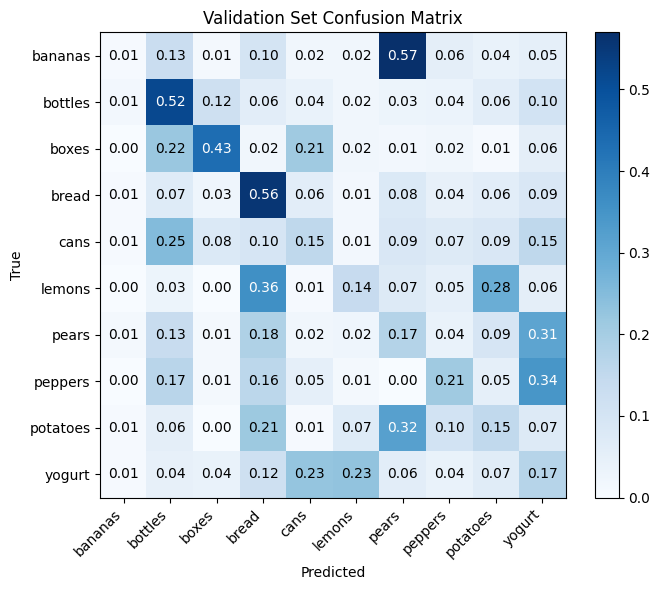

Test Accuracy: 0.1297
              precision    recall  f1-score   support

     bananas       0.00      0.00      0.00        64
     bottles       0.10      0.57      0.17        76
       boxes       0.34      0.55      0.42        76
       bread       0.00      0.00      0.00        83
        cans       0.09      0.24      0.13        75
      lemons       0.00      0.00      0.00        83
       pears       0.00      0.00      0.00        76
     peppers       1.00      0.01      0.03        69
    potatoes       0.00      0.00      0.00        70
      yogurt       0.00      0.00      0.00       130

    accuracy                           0.13       802
   macro avg       0.15      0.14      0.07       802
weighted avg       0.14      0.13      0.07       802



/opt/anaconda3/envs/mytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/mytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/mytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

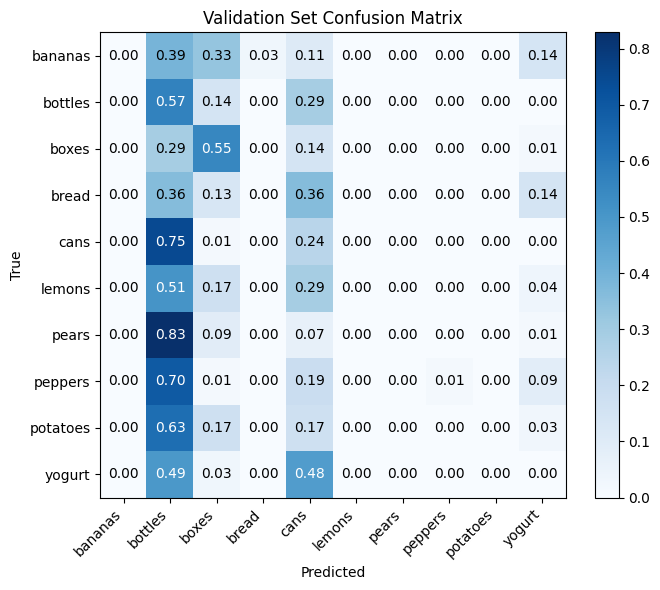

In [31]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report

# 1. 加载验证阶段保存的最优模型权重
model.load_state_dict(torch.load(best_path, map_location=device))

for i in range(4):
    model.eval()

    # 2. 构造测试集的 DataLoader
    test_ds    = TensorDataset(
        torch.from_numpy(test_feats_list[i]).float(),
        torch.from_numpy(test_labels_list[i]).long()
    )
    test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

    # 3. 分批推理，收集所有预测
    all_preds = []
    with torch.no_grad():
        for Xb, _ in test_loader:
            Xb = Xb.to(device)
            outs = model(Xb)    
            preds = outs.argmax(dim=1).cpu()
            all_preds.append(preds)
    # 合并为一个一维数组
    all_preds = torch.cat(all_preds).numpy()

    # 4. 计算整体准确率
    acc = (all_preds == test_labels_list[i]).mean()
    print(f"Test Accuracy: {acc:.4f}")

    classes = testset.classes

    # 5. 打印分类报告
    print(classification_report(test_labels_list[i], all_preds, target_names=classes))



    # 1. 先计算混淆矩阵（未归一化）
    cm = confusion_matrix(test_labels_list[i], all_preds)

    # 2. 对每一行（每个真实类别）做归一化，便于观察“召回率”
    cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    # 3. 可视化
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm_norm, interpolation='nearest', cmap='Blues')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # 4. 设置坐标轴刻度和标签
    # 之前定义的 CIFAR-10 类别列表
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.set_yticklabels(classes)

    # 5. 在每个单元格里写入数值
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            val = cm_norm[i, j]
            ax.text(j, i, f"{val:.2f}",
                    ha="center", va="center",
                    color="white" if val > thresh else "black")

    # 6. 标题和轴标签
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    ax.set_title('Validation Set Confusion Matrix')

    plt.tight_layout()
    plt.show()

In [ ]:
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import numpy as np

# # 1. 先计算混淆矩阵（未归一化）
# cm = confusion_matrix(test_labels, all_preds)

# # 2. 对每一行（每个真实类别）做归一化，便于观察“召回率”
# cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# # 3. 可视化
# fig, ax = plt.subplots(figsize=(8, 6))
# im = ax.imshow(cm_norm, interpolation='nearest', cmap='Blues')
# fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# # 4. 设置坐标轴刻度和标签
# # 之前定义的 CIFAR-10 类别列表
# ax.set_xticks(np.arange(len(classes)))
# ax.set_yticks(np.arange(len(classes)))
# ax.set_xticklabels(classes, rotation=45, ha='right')
# ax.set_yticklabels(classes)

# # 5. 在每个单元格里写入数值
# thresh = cm_norm.max() / 2.
# for i in range(cm_norm.shape[0]):
#     for j in range(cm_norm.shape[1]):
#         val = cm_norm[i, j]
#         ax.text(j, i, f"{val:.2f}",
#                 ha="center", va="center",
#                 color="white" if val > thresh else "black")

# # 6. 标题和轴标签
# ax.set_ylabel('True')
# ax.set_xlabel('Predicted')
# ax.set_title('Validation Set Confusion Matrix')

# plt.tight_layout()
# plt.show()

In [ ]:
class_names = testset.classes

# 随机选 5 张图来展示
for idx in random.sample(range(len(testset)), 5):
    # 1) 从 testset 拿到已 Resize、ToTensor 但未 Normalize 的图
    img_t, label = testset[idx]  
    # Tensor [C,H,W] -> NumPy H×W×C uint8
    img_np = (img_t.numpy().transpose(1,2,0) * 255).astype(np.uint8)

    # 2) 提取 BoVW 特征
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    kps  = detect_interest_points(gray, method=INTEREST_METHOD)
    des  = compute_custom_sift_descriptor(gray, kps)
    if des is None:
        hist = np.zeros(N_CLUSTERS, dtype=float)
    else:
        hist = build_bovw(des)

    # 3) 使用 Torch 模型进行预测
    x = torch.from_numpy(hist.reshape(1, -1)).float().to(device)
    model.eval()
    with torch.no_grad():
        out = model(x)
        pred = out.argmax(dim=1).item()

    # 4) 可视化：原图 + 真实/预测标签
    plt.figure(figsize=(4,4))
    plt.imshow(img_np)
    plt.title(f"GT: {class_names[label]}   Pred: {class_names[pred]}")
    plt.axis('off')
    plt.show()

## SVM

In [ ]:
# 1. 定义一个 Pipeline，把 StandardScaler 和 LinearSVC 串起来
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',    LinearSVC(dual=False, max_iter=500, random_state=42, verbose=2))
])

# 2. 指定要搜索的超参数网格
param_grid = {
    'svc__C':    [1],
    'svc__tol':  [1e-4]
}

# 3. 构造 GridSearchCV：5 折交叉验证，使用所有 CPU 核心
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    n_jobs=-1, # 使用所有 CPU 核心
    verbose=2, # 输出详细信息
    scoring='accuracy'
)

# 4. 在训练集上搜索最佳超参
grid.fit(train_feats, train_labels)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)



In [ ]:
# 5. 用最佳模型在测试集上评估
best_model = grid.best_estimator_
test_acc = best_model.score(test_feats, test_labels)
print(f"Test accuracy with best SVM: {test_acc:.4f}")

In [ ]:
# --- Randomly visualize classification results on test images ---
import matplotlib.pyplot as plt
# CIFAR-10 类别名称
class_names = testset.classes
# 随机选取几张图
for idx in random.sample(range(len(testset)), 10):
    img_t, label = testset[idx]
    # Tensor [C,H,W] 转为 HxWxC uint8 图像
    img_np = (img_t.numpy().transpose(1,2,0) * 255).astype(np.uint8)
    # 构建 BoVW 特征
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    kps = detect_interest_points(gray, method=INTEREST_METHOD)
    des = compute_custom_sift_descriptor(gray, kps)
    if des is None:
        hist = np.zeros(N_CLUSTERS, dtype=float)
    else:
        hist = build_bovw(des)
    # 标准化 & 预测
    # X = scaler.transform(hist.reshape(1, -1)) if 'scaler' in globals() else hist.reshape(1, -1)
    pred = best_model.predict(hist.reshape(1, -1))[0]
    # 可视化
    plt.figure(figsize=(4,4))
    plt.imshow(img_np)
    plt.title(f"GT: {class_names[label]}, Pred: {class_names[pred]}")
    plt.axis('off')
    plt.show()

In [ ]:
# # 定义 SVM 管道并开启 verbose 打印收敛信息，关闭 shrinking 提速
# svm_fast = make_pipeline(
#     StandardScaler(),
#     LinearSVC(
#         penalty='l2',
#         loss='squared_hinge',  # 改成 squared_hinge
#         dual=False,            # n_samples > n_features 时推荐 False
#         max_iter=5000,
#         tol=1e-4,
#         verbose=1
#     )
# )

# # 在 train_feats / train_labels 上训练
# svm_fast.fit(train_feats, train_labels)
# print("SVM training complete.")

In [ ]:
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# # 1. 预测
# svm_preds = svm_fast.predict(test_feats)

# # 2. 整体准确率
# acc = accuracy_score(test_labels, svm_preds)
# print(f"SVM Test Accuracy: {acc:.4f}")

# # 3. 详细报告
# print(classification_report(test_labels, svm_preds))

# # 4. （可选）混淆矩阵
# cm = confusion_matrix(test_labels, svm_preds)
# print("Confusion Matrix:")
# print(cm)

## KNN


In [ ]:
from sklearn.neighbors import KNeighborsClassifier


clf_knn = KNeighborsClassifier(n_neighbors=100, metric='euclidean', n_jobs=-1)
clf_knn.fit(train_feats, train_labels)
preds_knn = clf_knn.predict(test_feats)
acc_knn = accuracy_score(test_labels, preds_knn)
print(f"KNN Test Accuracy: {acc_knn:.4f}")

softmax:
Test Accuracy: 0.3903
              precision    recall  f1-score   support

       plane       0.39      0.38      0.38      1000
         car       0.56      0.31      0.40      1000
        bird       0.37      0.28      0.32      1000
         cat       0.29      0.27      0.28      1000
        deer       0.30      0.35      0.32      1000
         dog       0.40      0.30      0.34      1000
        frog       0.44      0.53      0.48      1000
       horse       0.41      0.36      0.38      1000
        ship       0.37      0.52      0.43      1000
       truck       0.44      0.60      0.51      1000

    accuracy                           0.39     10000
   macro avg       0.40      0.39      0.39     10000
weighted avg       0.40      0.39      0.39     10000

svm: 0.2520

knn: 0.1010